In [13]:
import io
import os
import pickle
from pathlib import Path
import pandas as pd
import torch
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [14]:
def get_last_in_path(path):
    return str(path).split('/')[-1]

In [15]:
run_project_name = 'test_name' # change accordingly
log_path = f'../../Scratch/merged-data/{run_project_name}'

In [16]:
results_path = '../../Scratch/merged-data/results'
images_path = '../../Scratch/merged-data/images'

# Collect data into DataFrame

In [17]:
from collections import defaultdict
d = []
check_list = defaultdict(list)


# Adapted from https://github.com/nik-sm/generator-surgery/blob/master/utils.py#L160 
# because our folder structure is modelled after theirs
for model_path in Path(results_path).iterdir():
    model = get_last_in_path(model_path)
    #print("model:", model)
    for dataset_path in model_path.iterdir():
        dataset = get_last_in_path(dataset_path)
        #print("dataset:", dataset)
        for img_path in dataset_path.iterdir():
            image = get_last_in_path(img_path)
            #print("image:", image)
            for fm_path in img_path.iterdir():
                forward_model = get_last_in_path(fm_path)
                #print("fm:", forward_model)
                for run_path in fm_path.iterdir():
                    run_params = get_last_in_path(run_path)
                    #print("run:", run_params)
                    for cut_path in run_path.iterdir():
                        cut = get_last_in_path(cut_path).split('=')[-1]
                        cut_split = cut[1:-1].split(',')
                        first_cut = int(cut_split[0])
                        second_cut = int(cut_split[1])
                        is_valid=1
                        #print("cut:", cut)
                        try: 
                            with open(cut_path / 'metrics.pkl', 'rb') as f:
                                metrics = pickle.load(f)
                            
                            recovered_img = torch.load(cut_path / 'recovered.pt', map_location=torch.device('cpu'))
                        except FileNotFoundError as err:
                            print('Could not find metrics.pkl from ', cut_path)
                            continue
                            
                        if metrics['TRAIN_MSE'] > 0.01:
                            # for a valid run, train_mse shouldn't be greater than 0.01
                            check_list[cut].append((image, recovered_img))
                            is_valid=0
                            # check the recovered_img
                        
                        row = {
                            'model': model,
                            'dataset': dataset,
                            'image': image,
                            'fm': forward_model,
                            'run': run_params,
                            'cut':cut,
                            'first_cut': first_cut,
                            'second_cut': second_cut,
                            'is_valid': is_valid,
                            **metrics
                        }
                        d.append(row)

                        
results_df = pd.DataFrame(d)

Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=3.z_number=1/cuts=[10, -1]
Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=3.z_number=1/cuts=[9, -1]
Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=3.z_number=1/cuts=[6, -1]
Could not find metrics.pkl from  ../../Scratch/merged-data/results/began/imagenet-val/ILSVRC2012_val_00034002/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=3.z_number=1/cuts=[7, -1]


In [18]:
for cut_idx in range(0,16):
    num_succeed = len(results_df[results_df['first_cut'] == cut_idx])
    cut = f'[{cut_idx}, -1]'
    if num_succeed == 0:
        print(f'==> ERROR: {cut_idx} has no runs!')
    else:
        print(f'==> Results for {cut_idx} had {num_succeed} runs and {len(check_list[cut])} invalid run')

==> Results for 0 had 30 runs and 2 invalid run
==> Results for 1 had 30 runs and 0 invalid run
==> Results for 2 had 30 runs and 0 invalid run
==> Results for 3 had 30 runs and 0 invalid run
==> Results for 4 had 30 runs and 0 invalid run
==> Results for 5 had 30 runs and 0 invalid run
==> ERROR: 6 has no runs!
==> ERROR: 7 has no runs!
==> Results for 8 had 30 runs and 1 invalid run
==> ERROR: 9 has no runs!
==> ERROR: 10 has no runs!
==> Results for 11 had 30 runs and 11 invalid run
==> Results for 12 had 30 runs and 28 invalid run
==> Results for 13 had 30 runs and 29 invalid run
==> Results for 14 had 30 runs and 27 invalid run
==> Results for 15 had 30 runs and 27 invalid run


# Record failure logs?

In [19]:
invalid_runs = dict()

for p in Path(log_path).iterdir():
    file_name = get_last_in_path(p)
    if not file_name.endswith('.txt'): 
        continue
    run_params = file_name[:-4] # abc.txt -> this removes .txt 
    cut = run_params.split('_')[-2].split('.')[-1].split('=')[1]
    
    # check if valid runs even exist:
    first_cut = int(cut.split(',')[0])
    num_succeed = len(results_df[(results_df['first_cut'] == first_cut)])
    if num_succeed == 0:
        invalid_runs[cut] = None
        continue
        
    with open(p, 'r') as f:
        lines = f.readlines()
        invalid_runs[cut] = set()
        if len(lines) > 0:
            # potentially invalid run for this particular run, store all the images which might be potentially invalid
            for line in lines:
                img_name = line.split('  ')[-2].split('.')[0]
                invalid_runs[cut].add(img_name)

In [20]:
import pprint

pprint.pprint({k: (-1 if v is None else len(v)) for k,v in invalid_runs.items()})

{'0,-1': 2,
 '1,-1': 0,
 '10,-1': -1,
 '11,-1': 11,
 '12,-1': 28,
 '13,-1': 29,
 '14,-1': 27,
 '15,-1': 27,
 '2,-1': 0,
 '3,-1': 0,
 '4,-1': 0,
 '5,-1': 0,
 '6,-1': -1,
 '7,-1': -1,
 '8,-1': 1,
 '9,-1': -1}


# Show failures

In [21]:
def show_failures(cut):
    failures = check_list['[' + cut + ']'].copy()
    num_failures = len(failures)
    
    print(f'Testing {cut}')
    print('Num failures: ', num_failures)

    nrows = max(1, math.ceil(num_failures / 4))
    ncols = num_failures // nrows

    if ncols == 0:
        print('No failures')
        return

    print(f'Rows: {nrows}\tCols:{ncols}')

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,9))
    fig.tight_layout()

    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx == num_failures:
                break
            # print(f'row:{row}\tcol:{col}\tidx:{idx}')
            img_name = failures[idx][0]
            
            img = failures[idx][1] 
            if nrows == 1 and ncols == 1:
                ax.set_title(img_name)
                ax.imshow(img.permute(1,2,0))
            elif nrows == 1 or ncols == 1:
                ax[idx].set_title(img_name)
                ax[idx].imshow(img.permute(1,2,0))
            else:
                ax[row][col].set_title(img_name)
                ax[row][col].imshow(img.permute(1,2,0))
            
    plt.show()

In [22]:
check_cut = '8, -1' # change accordingly

Testing 8, -1
Num failures:  1
Rows: 1	Cols:1


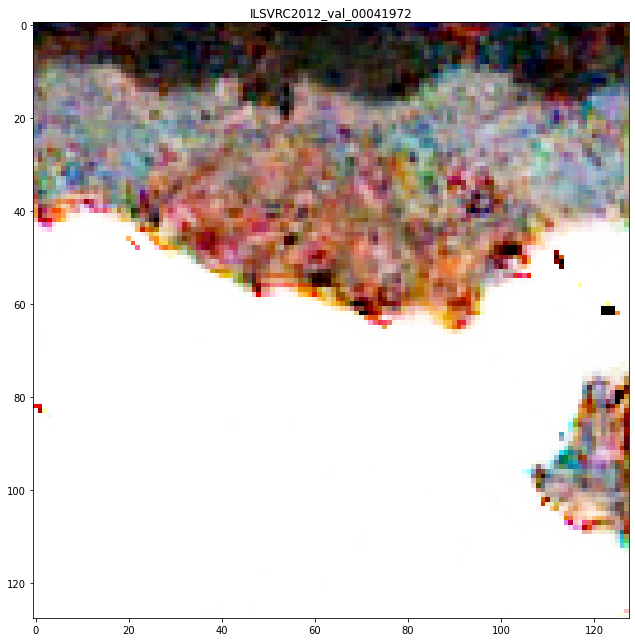

In [23]:
show_failures(check_cut)

# Remove some runs from results_df

In [55]:
def remove_image_from_df(df, img_names):
    orig_len = len(df)
    for img_name in img_names:
        df = df[df['image'] != img_name] # remove all rows where image is == img_name
    after_len = len(df)
    print(f'Removed {after_len - orig_len} rows')
    return df

In [56]:
results_df_cleaned = remove_image_from_df(results_df, ['ILSVRC2012_val_00041972', 'ILSVRC2012_val_00012614'])

Removed -24 rows


### Remove cuts which are bad

In [57]:
# remove cuts 11,-1 to 15,-1 as these are degenerate configurations
to_remove_cuts = [(11,-1), (12,-1), (13,-1), (14,-1), (15,-1)]

In [60]:
def remove_cuts(df, remove_cuts):
    orig_len = len(df)
    for first_cut, second_cut in to_remove_cuts:
        mask = ~((df['first_cut'] == first_cut) & (df['second_cut'] == second_cut))
        df = df[mask]
    after_len = len(df)
    print(f'Removed {after_len - orig_len} rows')
    return df

In [61]:
results_df_cleaned_final = remove_cuts(results_df_cleaned, to_remove_cuts)

Removed -140 rows


In [64]:
print('Final number of rows: ', len(results_df_cleaned_final))

Final number of rows:  196


# Verify successes are legit

### Here we should do a quick visualisation of all the images generated by a particular image (~30) to ensure that there are no outliers

In [106]:
results_df[(results_df['first_cut'] == 1) & (results_df['second_cut'] == -1)].iloc[0]

model                                                     began
dataset                                            imagenet-val
image                                   ILSVRC2012_val_00026848
fm                          InpaintingScatter.fraction_kept=0.1
run           tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs...
cut                                                     [1, -1]
first_cut                                                     1
second_cut                                                   -1
is_valid                                                      1
TRAIN_MSE                                              0.000329
ORIG_MSE                                                0.00668
ORIG_PSNR                                             21.752506
ORIG_LPIPS                                             0.279587
ORIG_SSIM                                              0.664994
time_taken                                            36.020922
Name: 11, dtype: object

In [144]:
def load_img_from_run_params(model, dataset, image, fm, run, cut):
    # returns pytorch tensor (C, H, W) representing the recovered image for the particular params
    # if doesn't exist, it raises a not found exception
    recovered_img_path = Path(results_path, model, dataset, image, fm, run, f'cuts={cut}') / 'recovered.pt'
    recovered_img = torch.load(recovered_img_path, map_location = torch.device('cpu'))
    return recovered_img

In [221]:
def visualize_gen_imgs(df, first_cut, second_cut):
    # generater plots showing all images generated by this cut on the particular dataset
    cut_df = df[(df['first_cut'] == first_cut) & (df['second_cut'] == second_cut)]
    imgs = cut_df['image']
    print(f'There are: {len(imgs)} images')
    ncols = 10 
    nrows = math.ceil(len(imgs) / ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
    # fig.tight_layout()
    max_c_del = None
    max_r_del = None

    
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx == len(imgs):
                max_c_del = col
                max_r_del = row
                break
            entry = cut_df.iloc[idx]
            recovered_img = load_img_from_run_params(
                model = entry['model'],
                dataset = entry['dataset'],
                image = entry['image'],
                fm = entry['fm'],
                run = entry['run'],
                cut = entry['cut']
            )
            ax[row][col].axis('off')
            ax[row][col].imshow( recovered_img.permute(1,2,0) )
    
    if max_c_del is not None and max_r_del is not None:
        for r_del in range(max_r_del, nrows):
            for c_del in range(max_c_del, ncols):
                fig.delaxes(ax[r_del,c_del])
        
    plt.subplots_adjust(wspace=0, hspace=0)
    

In [222]:
first_cut, second_cut = 3, -1

There are: 28 images


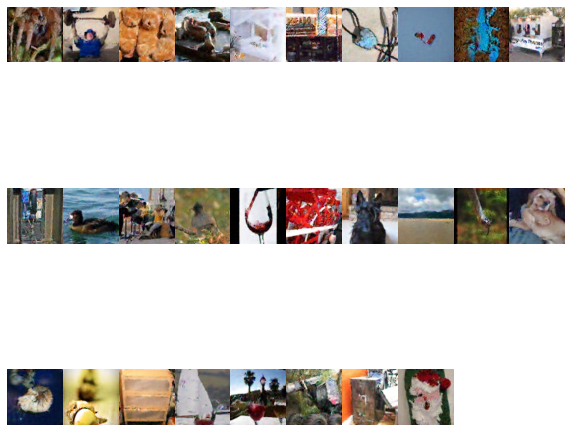

In [223]:
visualize_gen_imgs(results_df_cleaned_final, first_cut, second_cut)

# Analyze results

In [67]:
metrics = ['TRAIN_MSE', 'ORIG_MSE', 'ORIG_PSNR', 'ORIG_LPIPS', 'ORIG_SSIM', 'time_taken']

In [82]:
counts = results_df_cleaned_final.groupby('cut').size().to_frame(name='counts')

In [84]:
# Rank cuts by PSNR 
results_df_cleaned_final.groupby('cut').mean()[metrics].sort_values(by='ORIG_PSNR', ascending=False).join(counts)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,counts
cut,,,,,,,
"[3, -1]",0.000054,0.005114,23.807696,0.201457,0.737149,22.961579,28
"[2, -1]",0.000157,0.005382,23.534797,0.253580,0.705156,28.186070,28
"[4, -1]",0.000077,0.005430,23.419725,0.231939,0.720297,10.758279,28
"[5, -1]",0.000050,0.005891,23.287923,0.234903,0.720015,10.039434,28
"[1, -1]",0.000311,0.006083,22.904546,0.325250,0.663488,35.601339,28
"[8, -1]",0.000972,0.020729,18.986414,0.480737,0.520797,13.981257,28
"[0, -1]",0.002906,0.030003,15.654626,0.692643,0.294913,17.065089,28


In [85]:
results_df_cleaned_final.groupby('cut').mean()[metrics].sort_values(by='ORIG_LPIPS', ascending=True).join(counts)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,counts
cut,,,,,,,
"[3, -1]",0.000054,0.005114,23.807696,0.201457,0.737149,22.961579,28
"[4, -1]",0.000077,0.005430,23.419725,0.231939,0.720297,10.758279,28
"[5, -1]",0.000050,0.005891,23.287923,0.234903,0.720015,10.039434,28
"[2, -1]",0.000157,0.005382,23.534797,0.253580,0.705156,28.186070,28
"[1, -1]",0.000311,0.006083,22.904546,0.325250,0.663488,35.601339,28
"[8, -1]",0.000972,0.020729,18.986414,0.480737,0.520797,13.981257,28
"[0, -1]",0.002906,0.030003,15.654626,0.692643,0.294913,17.065089,28


In [86]:
results_df_cleaned_final.groupby('cut').mean()[metrics].sort_values(by='ORIG_SSIM', ascending=False).join(counts)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,counts
cut,,,,,,,
"[3, -1]",0.000054,0.005114,23.807696,0.201457,0.737149,22.961579,28
"[4, -1]",0.000077,0.005430,23.419725,0.231939,0.720297,10.758279,28
"[5, -1]",0.000050,0.005891,23.287923,0.234903,0.720015,10.039434,28
"[2, -1]",0.000157,0.005382,23.534797,0.253580,0.705156,28.186070,28
"[1, -1]",0.000311,0.006083,22.904546,0.325250,0.663488,35.601339,28
"[8, -1]",0.000972,0.020729,18.986414,0.480737,0.520797,13.981257,28
"[0, -1]",0.002906,0.030003,15.654626,0.692643,0.294913,17.065089,28
